In [585]:
'''
Credit goes to Mr. Georgio for creating the very helpful modules used in this file.
'''

'\nCredit goes to Mr. Georgio for creating the very helpful modules used in this file.\n'

### Imports and table functions

In [586]:
from pyscf import gto,scf, cc
import numpy as np
import pyscf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
from AP_class import APDFT_perturbator as AP
from alch_deriv import first_deriv_elec,DeltaV
from scipy.optimize import curve_fit
import numpy.fft as fft


In [587]:
def generate_table(data):
    # Determine the maximum width of each column
    column_widths = [max(len(str(row[i])) for row in data) for i in range(len(data[0]))]

    # Generate the table header
    table = generate_table_row(data[0], column_widths)
    table += generate_table_row(['-' * width for width in column_widths], column_widths)

    # Generate the table rows
    for row in data[1:]:
        table += generate_table_row(row, column_widths)

    return table

def generate_table_row(row_data, column_widths):
    row = '|'
    for i, item in enumerate(row_data):
        row += f' {str(item):{column_widths[i]}} |'
    row += '\n'
    return row

def new_mol(mol_i,l_i, l_f):
    mol = FcM_like(mol_i,fcs=[-l_i,l_f])
    mf_mol=scf.RKS(mol)
    mf_mol.xc="PBE0"
    mf_mol.verbose = 0
    Te_mol=mf_mol.scf(dm0=mf_mol.init_guess_by_1e())
    elec_energy = round(mf_mol.energy_elec()[0],3)
    
    return [mol, mf_mol, elec_energy]

def d_Z_lambda(mol_i, mol_f,lam):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    e = 7/3
    num = (3/7)* (Z_f**e - Z_i**e)
    den = ((Z_i**e) + lam*(Z_f**e - Z_i**e))**(4/7)
    return num / den

def Z_diff(mol_i, mol_f):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    return Z_f - Z_i

def AG(mf,sites=[0,1]):
    grads=[]
    for site in sites:
        grads.append(first_deriv_elec(mf,DeltaV(mf.mol,[[site],[1]])))
    return np.array(grads)

def get_pred(mol_i,AG_i, e_i,l_i,l_f):
    '''Returns the linear Z and non linear Z prediction 
    from mol_i using it's alchemical grad and energy
    at specific perturbation l_i, l_f at the individual atoms'''
    
    mol = FcM_like(mol_i,fcs=[-l_i,l_f])
    return np.round([e_i + np.dot(Z_diff(mol_i,mol), AG_i),e_i + np.dot(d_Z_lambda(mol_i,mol,0), AG_i)],3) 


### Defining my molecules

In [588]:
# uncontracted cc-pvdz
d = 2.1
NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}",unit="Bohr",basis='unc-ccpvdz')
mf_NN, e_NN = new_mol(NN, 0,0)[1],new_mol(NN, 0,0)[2]  
CO, mf_CO, e_CO = new_mol(NN, 1,1) 
BF, mf_BF, e_BF = new_mol(NN, 2,2) 

e_BeNe, e_LiNA,e_HeMg, e_HAl, e_Si = new_mol(NN,3,3)[2],new_mol(NN,4,4)[2], new_mol(NN,5,5)[2],\
                                    new_mol(NN,6,6)[2],new_mol(NN,7,7)[2],

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


In [589]:
'''Data for lambda = 5 and = 7 is stored in data folder'''
## Calculating actual fractional charge energies
max_lam = 7
frac_energies = np.loadtxt(f'data/dft_0_to_{max_lam}.csv')

# frac_energies = []
# i = 0

# while round(i,3) <= max_lam:
#     e_mol = new_mol(NN, i,i)[2]
#     frac_energies.append(e_mol)
#     i  += 0.1
# frac_energies = np.array(frac_energies)z

### Gradients from NN to CO and BF

In [590]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

AG_NN = AG(mf_NN) # the alchemical gradient i.e. d_E / d_Z_I

# calculating linear and non-linear energy gradients
nl_grad_NN_to_CO = round(np.dot(Z_diff(NN, CO), AG_NN),3)
l_grad_NN_to_CO = round(np.dot(d_Z_lambda(NN,CO,lam), AG_NN),3)

nl_grad_NN_to_BF = round(np.dot(Z_diff(NN, BF), AG_NN),3)
l_grad_NN_to_BF = round(np.dot(d_Z_lambda(NN,BF,lam), AG_NN),3)


In [591]:
'''Giorgio's idea'''
A_N1  = AG_NN[0]*3/7*7**(-4/3)
E_CO_pred = e_NN + A_N1*( 6**(7/3)+8**(7/3)-2*7**(7/3))
E_CO_pred

-136.8681760876302

### Gradients from CO to NN and BF

In [592]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

AG_CO = AG(mf_CO)

# calculating linear and non-linear energy gradients
nl_grad_CO_to_NN = round(np.dot(Z_diff(CO, NN), AG_CO),3)
l_grad_CO_to_NN = round(np.dot(d_Z_lambda(CO,NN,lam), AG_CO),3)

nl_grad_CO_to_BF = round(np.dot(Z_diff(CO, BF), AG_CO),3)
l_grad_CO_to_BF = round(np.dot(d_Z_lambda(CO,BF,lam), AG_CO),3)

### Gradients from BF to CO and NN

In [593]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

AG_BF = AG(mf_BF)

# calculating linear and non-linear energy gradients
nl_grad_BF_to_NN = round(np.dot(Z_diff(BF, NN), AG_BF),3)
l_grad_BF_to_NN = round(np.dot(d_Z_lambda(BF,NN,lam), AG_BF),3)

nl_grad_BF_to_CO = round(np.dot(Z_diff(BF, CO), AG_BF),3)
l_grad_BF_to_CO = round(np.dot(d_Z_lambda(BF,CO,lam), AG_BF),3)

In [594]:
'''Preparing prediction data for plotting for symmetrical alchemical changes'''
steps = max_lam * 10 # ensures a 0.1 step size
def gen_data(mol,AG,e_mol,l_i, l_f):
    l_pre = []
    nl_pre = []
    for i in np.linspace(l_i,l_f, steps + 1):
        pre = get_pred(mol, AG, e_mol, i,i)
        l_pre.append(pre[0])
        nl_pre.append(pre[1])
    return np.array(l_pre), np.array(nl_pre)
    
pre_NN_l, pre_NN_nl = gen_data(NN,AG_NN,e_NN,0, max_lam)
pre_CO_l, pre_CO_nl = gen_data(CO,AG_CO,e_CO,-1, max_lam -1)
pre_BF_l, pre_BF_nl = gen_data(BF,AG_BF,e_BF,-2, max_lam -2)
prediction = np.array([pre_NN_nl, pre_CO_nl, pre_BF_nl])

In [595]:
'''Fititng quadratic errors'''
def fit(x, a, b, c):
    return a*(x-b)**2 + c

quad_err = frac_energies - prediction
x_axis = np.linspace(0,max_lam,steps + 1)

popt_NN, pcov_NN = curve_fit(fit, x_axis, quad_err[0],absolute_sigma=True)
fitted_err_NN = np.array(fit(x_axis, *popt_NN))

popt_CO, pcov_CO = curve_fit(fit, x_axis, quad_err[1],absolute_sigma=True)
fitted_err_CO = np.array(fit(x_axis, *popt_CO))

popt_BF, pcov_BF = curve_fit(fit, x_axis, quad_err[2],absolute_sigma=True)
fitted_err_BF = np.array(fit(x_axis, *popt_BF))

quad_adjusted_prediction = prediction +np.array([fitted_err_NN, fitted_err_CO, fitted_err_BF])

In [596]:
'''Fititng quartic error'''
def quart_fit(x, a, b, c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

quart_err = frac_energies - quad_adjusted_prediction
popt_NN, pcov_NN = curve_fit(quart_fit, x_axis, quart_err[0],absolute_sigma=True)
q_fitted_err_NN = np.array(quart_fit(x_axis, *popt_NN))

popt_CO, pcov_CO = curve_fit(quart_fit, x_axis,  quart_err[1],absolute_sigma=True)
q_fitted_err_CO = np.array(quart_fit(x_axis, *popt_CO))

popt_BF, pcov_BF = curve_fit(quart_fit, x_axis,  quart_err[2],absolute_sigma=True)
q_fitted_err_BF = np.array(quart_fit(x_axis, *popt_BF))

quart_adjusted_prediction = quad_adjusted_prediction +np.array([q_fitted_err_NN, q_fitted_err_CO, q_fitted_err_BF])

Text(0.5, 1.0, 'Predictions with a quadratic error adjusted')

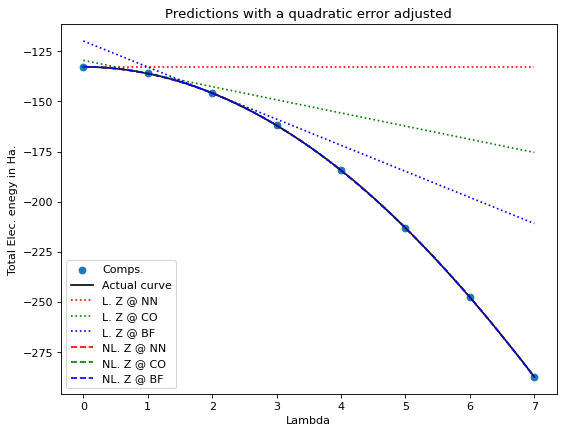

In [597]:
'''Plotting graph for symmetrical alchemical changes'''

# plotting the linearzied Z predictions
l_vals = np.array([np.array(x) for x in [pre_NN_l,pre_CO_l,pre_BF_l]])
# quad_vals = vals + np.array([np.zeros(steps + 1),fitted_err_NN,np.zeros(steps + 1),fitted_err_CO,np.zeros(steps + 1),fitted_err_BF])
# quartic_vals = quad_vals + np.array([np.zeros(steps + 1),q_fitted_err_NN,np.zeros(steps + 1),q_fitted_err_CO,np.zeros(steps + 1),q_fitted_err_BF])
l_keys = ['L. Z @ NN', 'L. Z @ CO','L. Z @ BF']
nl_keys = ['NL. Z @ NN','NL. Z @ CO','NL. Z @ BF']

l_lines = dict(zip(l_keys, l_vals))
nl_lines = dict(zip(nl_keys,quart_adjusted_prediction))
all_lines = {**l_lines, **nl_lines}

format = ['r:','g:', 'b:','r--','g--', 'b--']

figure(figsize=(8, 6), dpi=80)
plt.scatter([0,1,2,3,4,5,6,7],[e_NN, e_CO, e_BF, e_BeNe, e_LiNA, e_HeMg, e_HAl, e_Si],label='Comps.')
plt.plot(x_axis,np.array(frac_energies),'black',label='Actual curve')

i = 0
for line in all_lines:
    # plt.scatter(np.linspace(0,2,len(lines[line])),lines[line],label=line)
    plt.plot(x_axis,all_lines[line],format[i],label=line)
    i +=1
plt.legend()
plt.ylabel('Total Elec. enegy in Ha.')
plt.xlabel('Lambda')
plt.title('Predictions with a quadratic error adjusted')
# plt.savefig('main_curve',orientation='portrait')

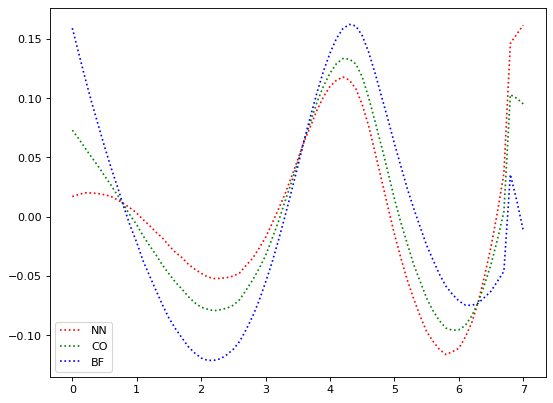

In [598]:
# plot the quadratic errors
figure(figsize=(8, 6), dpi=80)
plt.plot(x_axis,quad_err[0]-fitted_err_NN,'r:',label='NN')
plt.plot(x_axis,quad_err[1]-fitted_err_CO,'g:',label='CO')
plt.plot(x_axis,quad_err[2]-fitted_err_BF,'b:',label='BF')
plt.legend()


Text(0.5, 1.0, 'Error after adjusting quadratic')

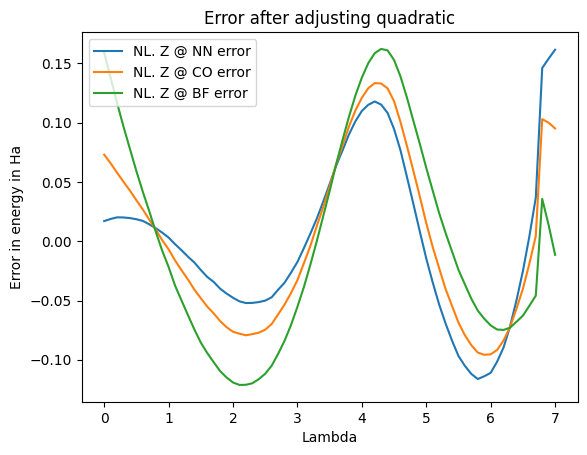

In [599]:
'''Plotting after quad error is adjusted for symmetrical alchemical changes.'''
plt.plot(x_axis, frac_energies -quad_adjusted_prediction[0],label='NL. Z @ NN error')
plt.plot(x_axis, frac_energies - quad_adjusted_prediction[1],label='NL. Z @ CO error')
plt.plot(x_axis, frac_energies - quad_adjusted_prediction[2],label='NL. Z @ BF error')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Error in energy in Ha')
plt.title('Error after adjusting quadratic')

Text(0.5, 1.0, 'After adjusting quaritc errors')

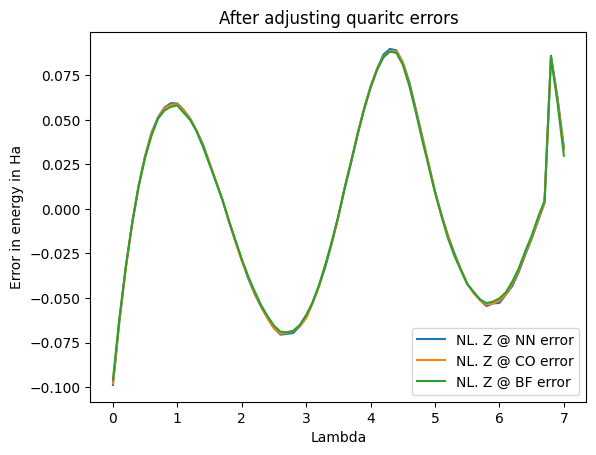

In [600]:
'''Plotting after quartic error is adjusted for symmetrical alchemical changes.'''
plt.plot(x_axis, frac_energies - quartic_vals[1],label='NL. Z @ NN error')
plt.plot(x_axis, frac_energies - quartic_vals[3],label='NL. Z @ CO error')
plt.plot(x_axis, frac_energies - quartic_vals[5],label='NL. Z @ BF error')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Error in energy in Ha')
plt.title('After adjusting quaritc errors')

Text(0, 0.5, 'Predicted energies')

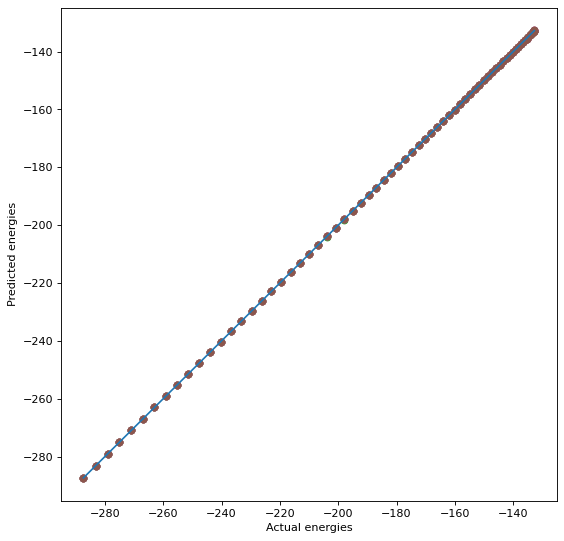

In [601]:
'''Plotting predicted vs actual energy 
for actual, pred, quad adjusted, quartic error adjusted '''
figure(figsize=(8, 8), dpi=80)
plt.plot(frac_energies, frac_energies,label='actual')
# plt.scatter(frac_energies, vals[1],'Pre. NN')
# plt.scatter(frac_energies, vals[3],'Pre. CO')
# plt.scatter(frac_energies, vals[5],'Pre. NN')

plt.scatter(frac_energies, quad_vals[1])
plt.scatter(frac_energies, quad_vals[3])
plt.scatter(frac_energies, quad_vals[5])

plt.scatter(frac_energies, quartic_vals[1])
plt.scatter(frac_energies, quartic_vals[3])
plt.scatter(frac_energies, quartic_vals[5])
plt.xlabel('Actual energies')
plt.ylabel('Predicted energies')

In [602]:
# def ff1(lam, C1,f1,p1):
#     return C1* np.sin(lam*f1 + p1)

# popt_NN, pcov_NN = curve_fit(ff1, x_axis, quad_err[0],absolute_sigma=True)

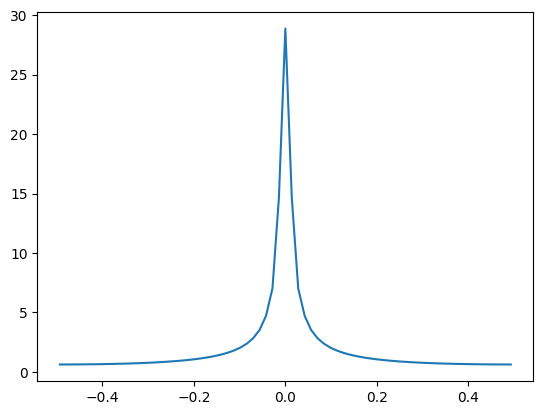

In [603]:
f1 = np.abs(2/steps*fft.fftshift(fft.fft(quad_err[0])))
frequencies = fft.fftfreq(steps+1,1)
frequencies = fft.fftshift(frequencies)

plt.plot(frequencies, f1)
# plt.plot(frequencies,y_dat,label='fft')

In [604]:
# make nth order fourier series approximation to a function
def fourier_series(x, f, n_max=10):
    # make the fourier series
    fseries = np.zeros_like(x)
    for n in range(1, n_max):
        fseries += f[n] * np.sin(2 * np.pi * n * x)
    return fseries

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


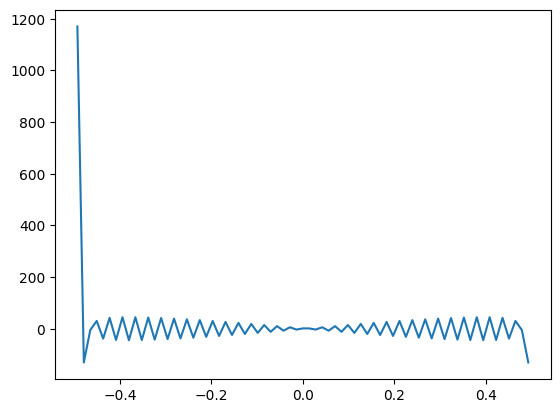

In [605]:
parabola = fft.fftshift(x_axis**2 + 0.014*x_axis - 0.017)
frequencies = fft.fftfreq(steps+1,1)
frequencies = fft.fftshift(frequencies)

plt.plot(frequencies, fft.fft(parabola))

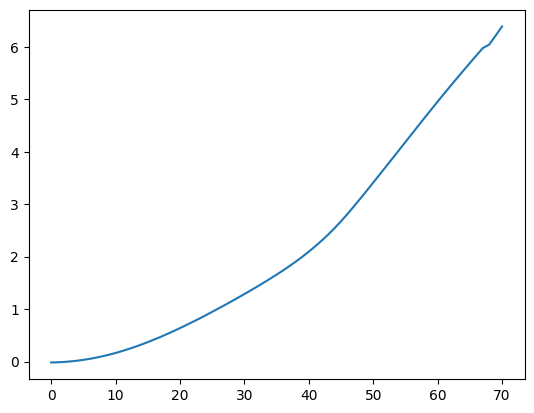

In [606]:
plt.plot(x_axis**2 + 0.014*x_axis - 0.017 - quad_err[0])

In [607]:
'''Preparing data for plotting for asymmetrical alchemical changes'''
# from_NN_l = []
# from_NN_nl = []
# steps = 50
# for i in np.linspace(0,5, steps + 1):
#     pre = get_pred(NN, AG_NN, e_NN, i,i)
#     from_NN_l.append(pre[0])
#     from_NN_nl.append(pre[1])
    
# from_CO_l = []
# from_CO_nl = []
# for i in np.linspace(-1,4, steps + 1):
#     pre = get_pred(CO, AG_CO, e_CO, i,i)
#     from_CO_l.append(pre[0])
#     from_CO_nl.append(pre[1])

# from_BF_l = []
# from_BF_nl = []
# for i in np.linspace(-2,3, steps + 1):
#     pre = get_pred(BF, AG_BF, e_BF, i,i)
#     from_BF_l.append(pre[0])
#     from_BF_nl.append(pre[1])

'Preparing data for plotting for asymmetrical alchemical changes'

#### getting average linearizing coeffecient = ratio of nl_grad to l_grad

In [608]:
def lin_coeff():
    nl_grads= np.array([nl_grad_CO_to_NN, nl_grad_CO_to_BF,
                        nl_grad_BF_to_NN, nl_grad_BF_to_CO])

    l_grads= np.array([l_grad_CO_to_NN, l_grad_CO_to_BF,
                        l_grad_BF_to_NN, l_grad_BF_to_CO])

    # nl_grads = np.append(nl_grads,[nl_grad_NN_to_BF, nl_grad_NN_to_CO])
    # l_grads = np.append(l_grads,[l_grad_NN_to_BF, l_grad_NN_to_CO])
    C = round(np.mean(l_grads / nl_grads),3)

    NN_pred = ['NN','-', e_NN + C *nl_grad_NN_to_CO ,  e_NN + C *nl_grad_NN_to_BF]
    CO_pred = ['CO',e_CO + C *nl_grad_CO_to_NN,'-' ,  e_CO + C *nl_grad_CO_to_BF]
    BF_pred = ['BF',e_BF + C *nl_grad_BF_to_NN,e_BF + C *nl_grad_BF_to_CO,'-' ]

    data = [
        ['From \ To', 'NN', 'CO','BF'],
        ['NN',e_NN, e_NN + C *nl_grad_NN_to_CO ,  e_NN + C *nl_grad_NN_to_BF],
        ['CO',round(e_CO + C *nl_grad_CO_to_NN,3),e_CO ,  round(e_CO + C *nl_grad_CO_to_BF,3)],
        ['BF',round(e_BF + C *nl_grad_BF_to_NN,3),round(e_BF + C *nl_grad_BF_to_CO,3),e_BF ]
    ]
    table = generate_table(data)
    print('Using average of linearizing coeffecient at CO and BF')
    print()
    print(table)

In [609]:
def nl_grad():
    print('Predictions from NN, CO and BF just using non-linear energy gradient')
    print()
    data = [
        ['From \ To', 'NN','err','CO','err','BF','err'],
        ['NN', e_NN, 0,e_NN + nl_grad_NN_to_CO,round(e_NN + nl_grad_NN_to_CO - e_CO,3),e_NN + nl_grad_NN_to_BF,round(e_NN + nl_grad_NN_to_BF - e_BF,3)],
        ['CO',e_CO + nl_grad_CO_to_NN,round(e_CO + nl_grad_CO_to_NN - e_NN,3),e_CO,0, e_CO + nl_grad_CO_to_BF,round(e_CO + nl_grad_CO_to_BF-e_BF,3)],
        ['BF',e_BF + nl_grad_BF_to_NN,round(e_BF + nl_grad_BF_to_NN - e_NN,3),e_BF + nl_grad_BF_to_CO,round(e_BF + nl_grad_BF_to_CO - e_CO,3),e_BF,0 ]
    ]
    table = generate_table(data)
    print(table)
    print(f'NN actual energy = {e_NN}, \nCO actual energy = {e_CO}, \nBF actual energy = {e_BF}, \n')

In [610]:
def hessian():
    '''Using Hessian'''
    # modelling ax^2 + bx + c
    a = -0.139 - 3.126
    b = 0
    c = -132.748
    def app(l):
        return round(a*l**2 + b*l + c,3)

    print('Prediction of energies via the Hessian')
    print()
    data = [['Mol \ Method', 'Actual (PBE; unc-ccpvdz with RKS)','Hessian from paper','Descrepency'],
            [
                'NN',e_NN, app(0),e_NN-app(0), 
            ],
            [
                'CO',e_CO, app(1),round(e_CO-app(1),3), 
            ],
            [
                'BF',e_BF, app(2),round(e_BF-app(2),3), 
            ]
            
            ]
    table = generate_table(data)
    print(table)

In [611]:
'''Matrix with linear interpolation in Z'''
print('Predictions from NN, CO and BF just using linear Z / non-linear energy gradient')
print()
data = [
    ['From \ To', 'NN','CO','BF'],
    ['NN', e_NN,e_NN + nl_grad_NN_to_CO,e_NN + nl_grad_NN_to_BF],
    ['CO',e_CO + nl_grad_CO_to_NN,e_CO, e_CO + nl_grad_CO_to_BF],
    ['BF',e_BF + nl_grad_BF_to_NN,e_BF + nl_grad_BF_to_CO,e_BF]
]
table = generate_table(data)
print(table)

Predictions from NN, CO and BF just using linear Z / non-linear energy gradient

| From \ To | NN       | CO       | BF       |
| --------- | -------- | -------- | -------- |
| NN        | -132.748 | -132.748 | -132.748 |
| CO        | -129.47  | -136.035 | -142.6   |
| BF        | -119.826 | -132.831 | -145.837 |



In [612]:
'''Matrix with linear interpolation in Z'''
print('Predictions from NN, CO and BF just using non-linear Z / linear energy gradient between pairs')
print()
data = [
    ['From \ To', 'NN','CO','BF'],
    ['NN', e_NN,e_NN + l_grad_NN_to_CO,round(e_NN + l_grad_NN_to_BF,3)],
    ['CO',e_CO + l_grad_CO_to_NN,e_CO, e_CO + l_grad_CO_to_BF],
    ['BF',round(e_BF + l_grad_BF_to_NN,3),e_BF + l_grad_BF_to_CO,e_BF]
]
table = generate_table(data)
print(table)

Predictions from NN, CO and BF just using non-linear Z / linear energy gradient between pairs

| From \ To | NN       | CO       | BF       |
| --------- | -------- | -------- | -------- |
| NN        | -132.748 | -136.868 | -149.21  |
| CO        | -133.628 | -136.035 | -146.739 |
| BF        | -136.931 | -137.093 | -145.837 |

